In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import astropy.units as u
import astropy.constants as c
import astropy.units as cu
from astropy.cosmology import Planck15 as cosmo
from Corrfunc.mocks.DDtheta_mocks import DDtheta_mocks
from Corrfunc.utils import convert_3d_counts_to_cf
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools

### angular auto 2pcf in TNG snapshots around $z\sim 0.5$

In [3]:
def compute_wtheta_auto(gal_pos, chi, theta_edges, runit=u.Mpc/cu.littleh):
    assert gal_pos_spec.shape[1] == 3
    
    # units
    gal_pos = gal_pos.to(runit).value if isinstance(gal_pos, u.Quantity) else gal_pos
    chi = chi.to(runit).value if isinstance(chi, u.Quantity) else chi
    theta_edges = theta_edges.to(u.deg).value if isinstance(theta_edges, u.Quantity) else theta_edges
    
    # convert cartesian (x,y,z) to 2D (RA,Dec)
    gal_pos_ = np.copy(gal_pos)
    gal_pos_[:,2] = 0
    ra, dec = tools.CartesiantoEquatorial(gal_pos_, observer=[0.,0.,chi])
    ra = ra.value
    dec = dec.value

    # random catalog
    nd = len(gal_pos_)
    ra_rand = np.random.uniform(min(ra), max(ra), nd)
    dec_rand = np.random.uniform(min(dec), max(dec), nd)
    
    return corrfuncs.wtheta_auto(ra, dec, ra_rand, dec_rand, theta_edges)

In [4]:
# construct SPHEREx-like galaxy samples and compute angular auto 2pcf
snapshots = np.arange(65, 79).astype(int)

sigma_z = 0.01  # one of the 5 redshift error bins in SPHEREx

# bin edges for Corrfunc
theta_edges = np.deg2rad(np.logspace(np.log10(0.01), np.log10(5.), 10)) << u.deg

redshifts = np.empty(len(snapshots))
chis = np.empty(len(snapshots))
wthetas = np.empty((len(snapshots), len(theta_edges)-1))
gal_pos_specs = []
for i, snapshot in enumerate(snapshots):
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    chi = tools.redshift_to_comov(sim.redshift)
    redshifts[i] = sim.redshift
    chis[i] = chi.value

    gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
    gal_pos_spec -= sim.boxsize / 2
    gal_pos_specs.append(gal_pos_spec)
    
    thetaavg, wthetas[i] = compute_wtheta_auto(gal_pos_spec, chi, theta_edges)

chis *= chi.unit  # give unit back to the chis

 number density for SPHEREx at z=0.55: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.52: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.48: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.46: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.44: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.42: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.4: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
 number density for SPHEREx at z=0.38: 8.56e-03 (h/Mpc)^3 
target number of subhalos: 73745
 number density for SPHEREx at z=0.36: 8.56e-03 (h/Mpc)^3 
target number of subhalos: 73745
 number density for SPHEREx at z=0.35: 8.56e-03 (h/Mpc)^3 
target number of subhal

Text(0.5, 1.0, 'Angular auto 2pcf: SPHEREx-like galaxies from TNG300-3')

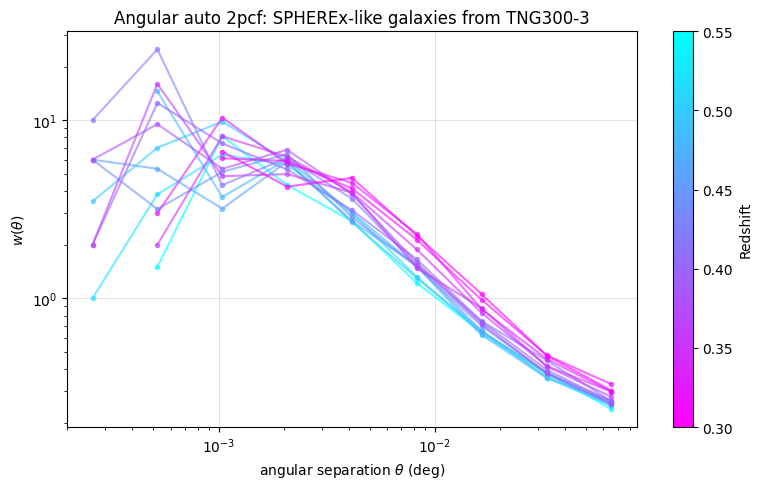

In [5]:
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')

fig, ax = plt.subplots(figsize=(8,5), tight_layout=True)
for i, wtheta in enumerate(wthetas):
    ax.plot(thetaavg, wtheta, marker='.', alpha=0.6, c=smap.to_rgba(redshifts[i]))
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.set_ylabel(r'$w(\theta)$')
fig.colorbar(smap, ax=ax, label='Redshift')
ax.set_title('Angular auto 2pcf: SPHEREx-like galaxies from TNG300-3')

Linear theory:
$$
C_\mathrm{lin}(\ell) \approx \frac{H(\bar z)}{c}\frac{\Delta \bar z}{\chi^2(\bar z)}\,P_\mathrm{lin}\left(k=\frac{\ell+1/2}{\chi},\bar z\right)
$$

$$
w_\mathrm{lin}(\theta) = \int\frac{\mathrm{d}\ell}{2\pi}\,\ell\, J_0(\ell\theta)\,C_\mathrm{lin}(\ell)
$$

Compare to cross power:
$$
C(\ell) \approx \frac{\Delta\chi}{\chi^2(\bar z)}\,W_\mathrm{phot}(\chi)\,W_i\,b_\mathrm{phot}(\bar z)\,b_i(\bar z) \,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$

### how much distance between snapshots?

Text(0.5, 1.0, 'TNG300 snapshots')

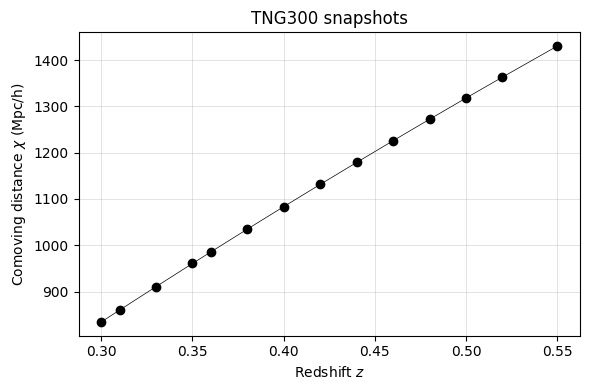

In [29]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, chis, 'ko-', lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Comoving distance $\chi$ (Mpc/h)')
ax.set_title(f'TNG300 snapshots')

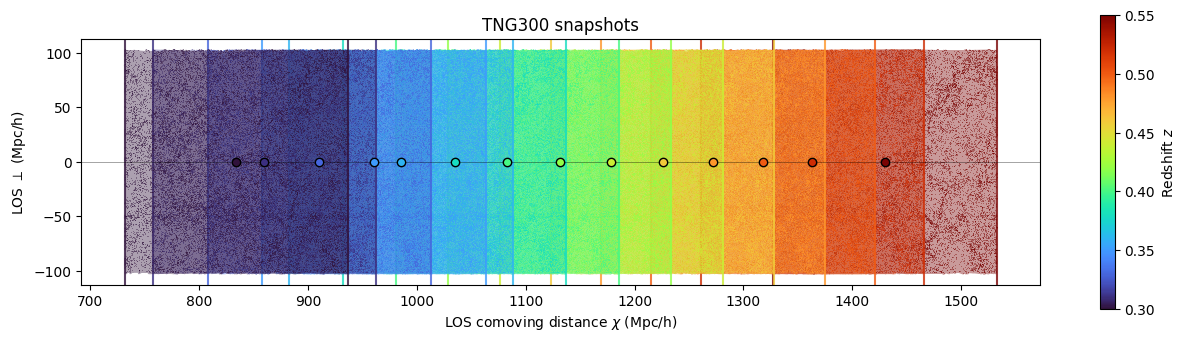

In [44]:
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(13,3.5), tight_layout=True)
for i, chi in enumerate(chis):
    gal_pos_spec_ = np.copy(gal_pos_specs[i])
    gal_pos_spec_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(redshifts[i]))
    ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.4, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - sim.boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + sim.boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_aspect('equal')
ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
ax.set_title(r'TNG300 snapshots')
fig.colorbar(smap, ax=ax, label='Redshift $z$')